### Make Figures 1, 3, and 4
Plot metrics for all algorithms vs number of agents. Before running this notebook, produce the summary metric csvs by running python3 run_baselines_on_semisynth.py model_type num_agents subset with the product of these arguments:
- model_type: Iterative, Direct, ULearner, CausalForest, TARNet
- num_agents: 2, 5, 10, 20, 40, 87
- subset: drug_possession, misdemeanor_under35

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

In [2]:
num_agents = [2,5,10,20,40,87]
baseline_types = ['Direct', 'ULearner', 'CausalForest', 'TARNet', 'Iterative']
baseline_type_human_readable = {'Direct': 'Direct', 'ULearner': 'U-learner', 'CausalForest': 'Causal forest', 
                                'TARNet': 'TARNet', 'Iterative': 'Iterative (Ours)'}
secondary_classes = ['LogisticRegression', 'DecisionTree', 'RandomForest']
secondary_class_abrv = {'LogisticRegression': 'RR', 'DecisionTree': 'DT', 
                        'RandomForest': 'RF'}

In [3]:
def load_data(subset_name):
    all_df = None
    all_partition_acc_df = None
    for n_agents, baseline_type in product(num_agents, baseline_types):
        if baseline_type == 'Iterative':
            for secondary_class in secondary_classes:
                df = pd.read_csv('semisynth_logit15_' + subset_name + '_numagents' + str(n_agents) + '_baselines/' \
                                 + baseline_type + '_' + secondary_class + '_summary_metrics.csv')
                df['Method'] = [secondary_class_abrv[secondary_class] + ' ' + baseline_type_human_readable[baseline_type] \
                                for i in range(len(df))]
                df['Num agents'] = [n_agents for i in range(len(df))]
                if 'Partition accuracy' in df.columns:
                    partition_acc_df = df[['Num agents','Method','Partition accuracy']]
                    if all_partition_acc_df is None:
                        all_partition_acc_df = partition_acc_df
                    else:
                        all_partition_acc_df = pd.concat((all_partition_acc_df, partition_acc_df), ignore_index=True)
                if all_df is None:
                    all_df = df
                else:
                    all_df = pd.concat((all_df, df), ignore_index=True)
        else:
            df = pd.read_csv('semisynth_logit15_' + subset_name + '_numagents' + str(n_agents) + '_baselines/' \
                             + baseline_type + '_summary_metrics.csv')
            df['Method'] = [secondary_class_abrv[df['Model class'].iloc[i]] + ' ' \
                            + baseline_type_human_readable[baseline_type] for i in range(len(df))]
        df['Num agents'] = [n_agents for i in range(len(df))]
        if 'Partition accuracy' in df.columns:
            partition_acc_df = df[['Num agents','Method','Partition accuracy']]
            if all_partition_acc_df is None:
                all_partition_acc_df = partition_acc_df
            else:
                all_partition_acc_df = pd.concat((all_partition_acc_df, partition_acc_df), ignore_index=True)
        if all_df is None:
            all_df = df
        else:
            all_df = pd.concat((all_df, df), ignore_index=True)
    return all_df

In [4]:
drug_possession_df = load_data('drug_possession')

In [5]:
misdemeanor_under35_df = load_data('misdemeanor_under35')

### Figure 1
Plot the metrics with the best model class: ridge regression for drug possession and random forest for misdemeanor under 35

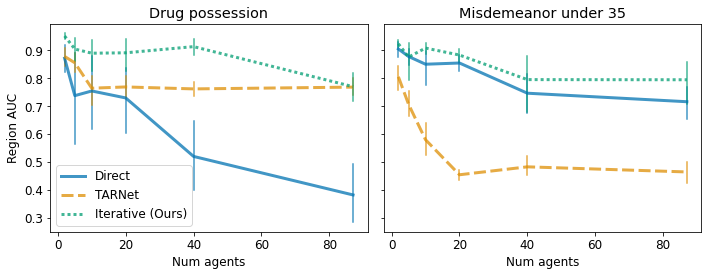

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4), sharey=True)
plt.rcParams.update({'font.size':12})
sns.lineplot(data=drug_possession_df.loc[drug_possession_df['Method'].isin({'RR Direct', 'RR TARNet', 
                                                                            'RR Iterative (Ours)'})], 
             x='Num agents',
             y='Region AUC',
             hue='Method',
             style='Method',
             ax=ax[0], 
             dashes=True,
             palette='colorblind',
             err_style="bars",
             alpha=0.75,
             linewidth=3,
             seed=0)
sns.lineplot(data=misdemeanor_under35_df.loc[misdemeanor_under35_df['Method'].isin({'RF Direct', 'RF TARNet', 
                                                                                    'RF Iterative (Ours)'})], 
             x='Num agents',
             y='Region AUC',
             hue='Method',
             style='Method',
             ax=ax[1], 
             dashes=True,
             palette='colorblind',
             err_style="bars",
             alpha=0.75,
             linewidth=3,
             seed=0)
ax[0].set_title('Drug possession')
ax[1].set_title('Misdemeanor under 35')
ax[1].get_legend().remove()
ax[0].legend(['Direct', 'TARNet', 'Iterative (Ours)'], loc='lower left')
plt.tight_layout()
plt.savefig('combined_semisynth_region_AUC_subset.pdf')

In [30]:
def plot_all_metric(all_df, subset_name):
    assert subset_name in {'drug_possession', 'misdemeanor_under35'}
    fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(18,16), sharey='row', sharex=True)
    plt.rcParams.update({'font.size':16})
    order = ['Direct', 'TARNet', 'Iterative (Ours)', 'U-learner', 'Causal forest']
    metric_names = ['Region AUC', 'Region precision', 'Region recall', 'Partition accuracy']
    for row_idx in range(len(metric_names)):
        sns.lineplot(data=all_df.loc[all_df['Method'].str.startswith('RR')], 
                     x='Num agents',
                     y=metric_names[row_idx],
                     hue='Method',
                     hue_order=['RR ' + i for i in order],
                     style='Method',
                     style_order=['RR ' + i for i in order],
                     ax=ax[row_idx,0], 
                     dashes=True,
                     palette='colorblind',
                     err_style="bars",
                     alpha=0.75,
                     linewidth=3,
                     seed=0)
        sns.lineplot(data=all_df.loc[all_df['Method'].str.startswith('DT')], 
                     x='Num agents',
                     y=metric_names[row_idx],
                     hue='Method',
                     hue_order=['DT ' + i for i in order],
                     style='Method',
                     style_order=['DT ' + i for i in order],
                     ax=ax[row_idx,1], 
                     dashes=True,
                     palette='colorblind',
                     err_style="bars",
                     alpha=0.75,
                     linewidth=3,
                     seed=0)
        sns.lineplot(data=all_df.loc[all_df['Method'].str.startswith('RF')], 
                     x='Num agents',
                     y=metric_names[row_idx],
                     hue='Method',
                     hue_order=['RF ' + i for i in order],
                     style='Method',
                     style_order=['RF ' + i for i in order],
                     ax=ax[row_idx,2], 
                     dashes=True,
                     palette='colorblind',
                     err_style="bars",
                     alpha=0.75,
                     linewidth=3,
                     seed=0)
        if row_idx == 0:
            if subset_name == 'drug_possession':
                title_header = 'Drug possession'
            else:
                title_header = 'Misdemeanor under 35'
            ax[row_idx,0].set_title('Ridge regression region')
            ax[row_idx,1].set_title('Decision tree region')
            ax[row_idx,2].set_title('Random forest region')
        ax[row_idx,0].get_legend().remove()
        ax[row_idx,1].get_legend().remove()
        if metric_names[row_idx] == 'Partition accuracy':
            ax[row_idx,2].legend(order)
        else:
            ax[row_idx,2].get_legend().remove()
    plt.tight_layout()
    plt.savefig(subset_name + '_semisynth_all.pdf')
    plt.show()

### Figure 3

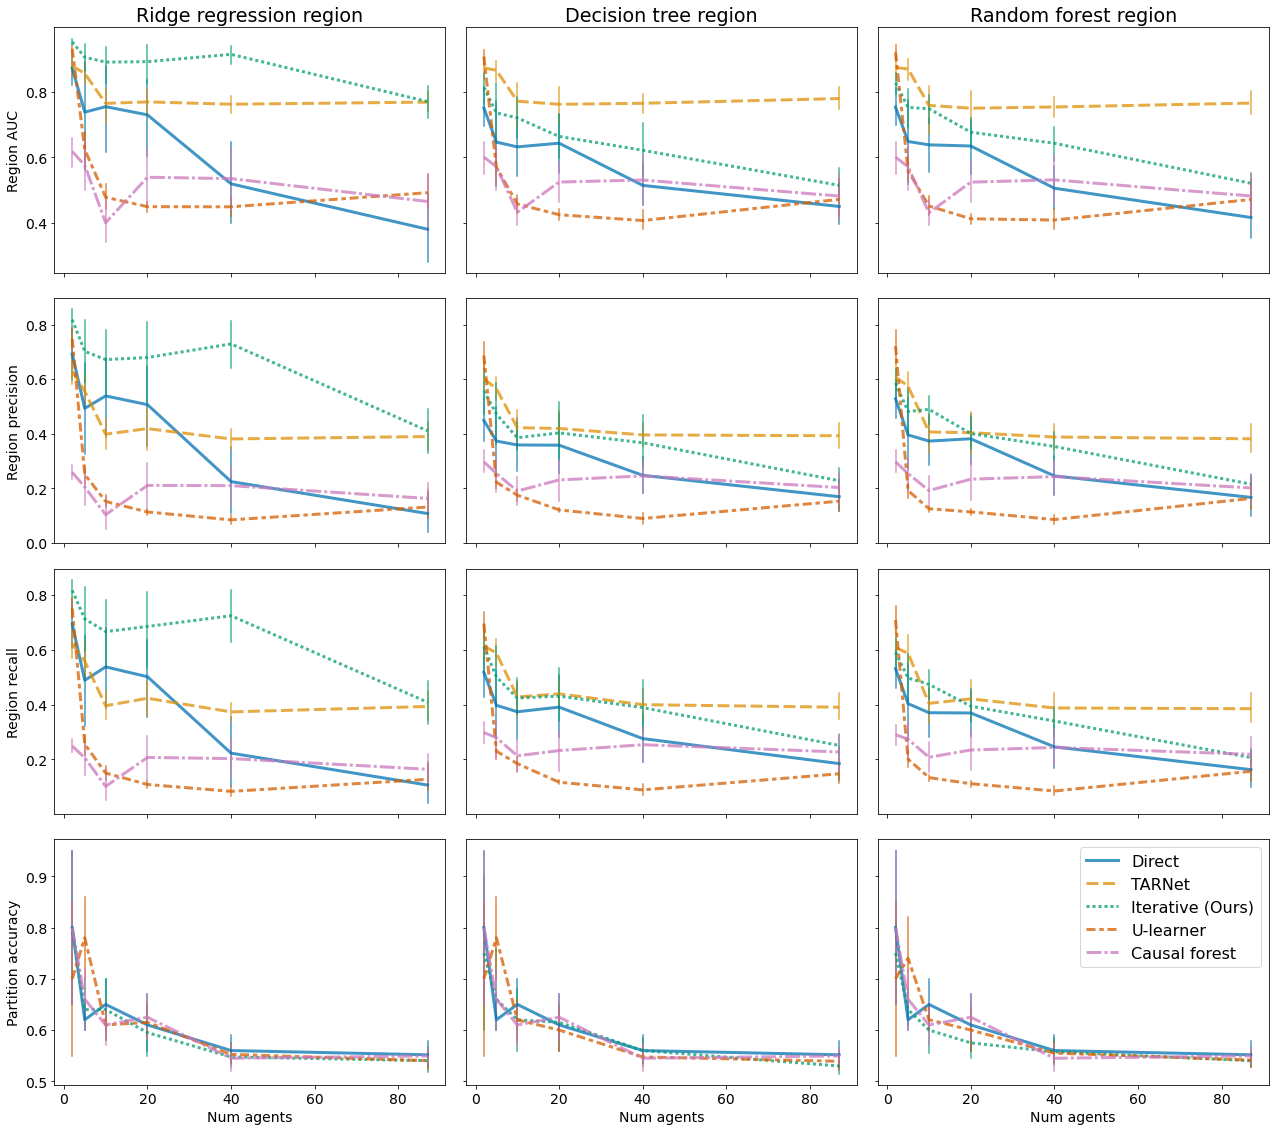

In [31]:
plot_all_metric(drug_possession_df, 'drug_possession')

### Figure 4

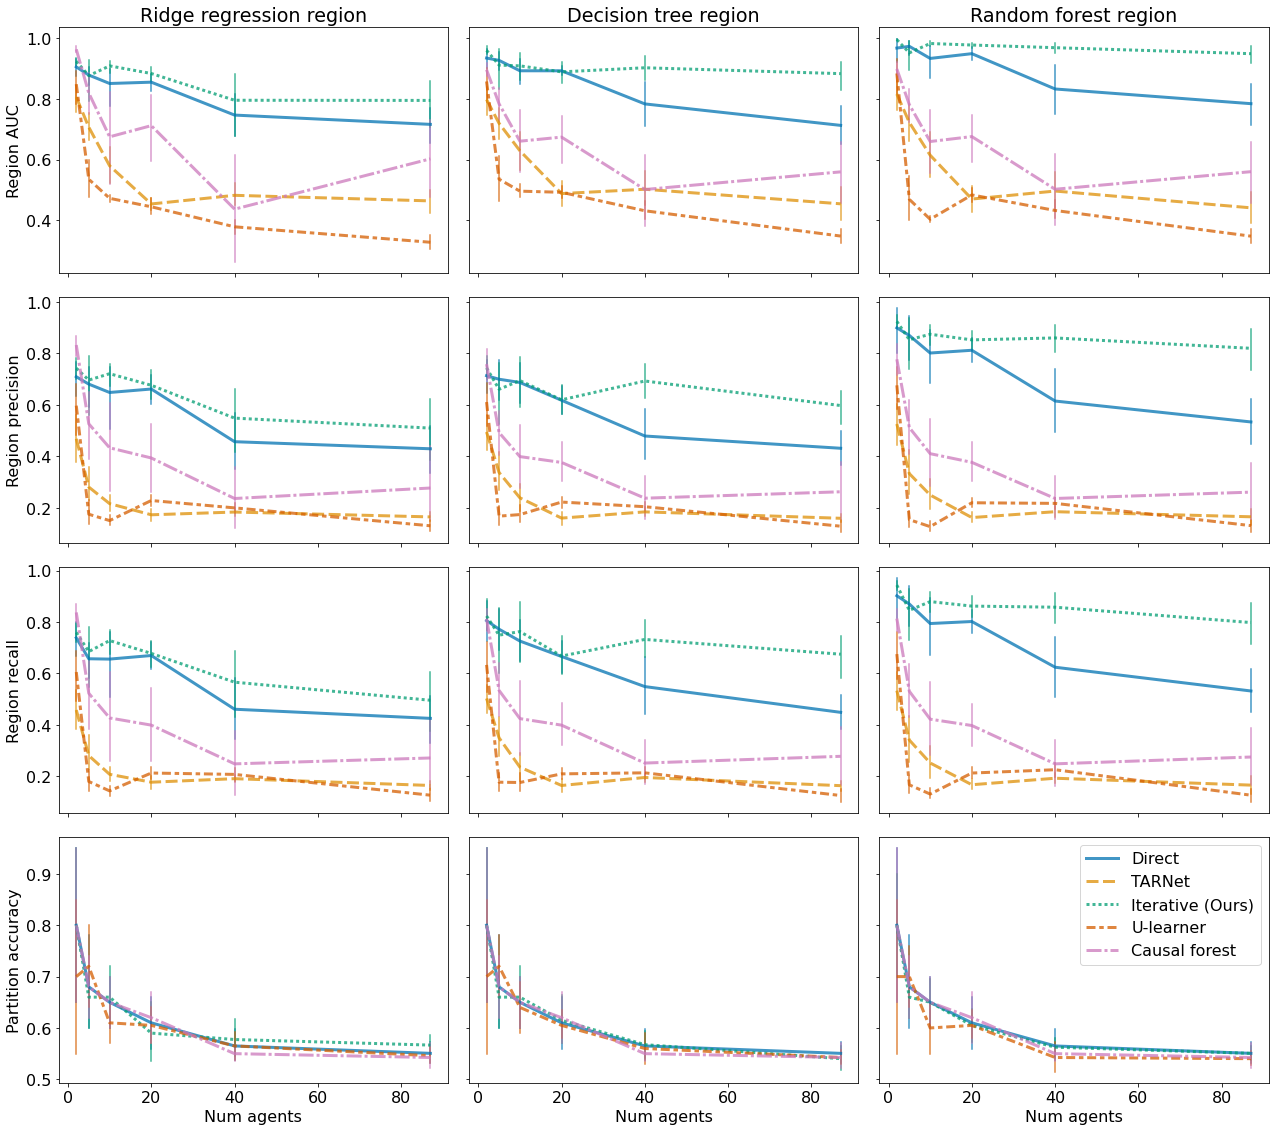

In [32]:
plot_all_metric(misdemeanor_under35_df, 'misdemeanor_under35')